# Lalonde Pandas API Example
by Adam Kelleher

We'll run through a quick example using the high-level Python API for the DoSampler. The DoSampler is different from most classic causal effect estimators. Instead of estimating statistics under interventions, it aims to provide the generality of Pearlian causal inference. In that context, the joint distribution of the variables under an intervention is the quantity of interest. It's hard to represent a joint distribution nonparametrically, so instead we provide a sample from that distribution, which we call a "do" sample.

Here, when you specify an outcome, that is the variable you're sampling under an intervention. We still have to do the usual process of making sure the quantity (the conditional interventional distribution of the outcome) is identifiable. We leverage the familiar components of the rest of the package to do that "under the hood". You'll notice some similarity in the kwargs for the DoSampler.

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

## Getting the Data

First, download the data from the LaLonde example.

In [2]:
import dowhy.datasets

lalonde = dowhy.datasets.lalonde_dataset()

## The `causal` Namespace

We've created a "namespace" for `pandas.DataFrame`s containing causal inference methods. You can access it here with `lalonde.causal`, where `lalonde` is our `pandas.DataFrame`, and `causal` contains all our new methods! These methods are magically loaded into your existing (and future) dataframes when you `import dowhy.api`.

In [3]:
import dowhy.api

Now that we have the `causal` namespace, lets give it a try! 

## The `do` Operation

The key feature here is the `do` method, which produces a new dataframe replacing the treatment variable with values specified, and the outcome with a sample from the interventional distribution of the outcome. If you don't specify a value for the treatment, it leaves the treatment untouched:

In [4]:
do_df = lalonde.causal.do(x='treat',
                          outcome='re78',
                          common_causes=['nodegr', 'black', 'hisp', 'age', 'educ', 'married'],
                          variable_types={'age': 'c', 'educ':'c', 'black': 'd', 'hisp': 'd', 
                                          'married': 'd', 'nodegr': 'd','re78': 'c', 'treat': 'b'},
                         proceed_when_unidentifiable=True)

Notice you get the usual output and prompts about identifiability. This is all `dowhy` under the hood!

We now have an interventional sample in `do_df`. It looks very similar to the original dataframe. Compare them:

In [5]:
lalonde.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75
0,False,23.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,1.0
1,False,26.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12383.68,1.0,1.0
2,False,22.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,1.0
3,False,18.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,10740.08,1.0,1.0
4,False,45.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,11796.47,1.0,1.0


In [6]:
do_df.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,propensity_score,weight
0,False,27.0,11.0,1.0,0.0,1.0,1.0,0.000,4491.8840,0.00000,1.0,0.0,0.584552,1.710711
1,True,27.0,13.0,1.0,0.0,0.0,0.0,0.000,0.0000,0.00000,1.0,1.0,0.529497,1.888586
2,True,26.0,11.0,1.0,0.0,1.0,1.0,0.000,1392.8530,1460.36000,1.0,0.0,0.413820,2.416507
3,True,27.0,12.0,1.0,0.0,1.0,0.0,3670.872,334.0493,0.00000,0.0,0.0,0.593597,1.684644
4,False,25.0,11.0,1.0,0.0,1.0,1.0,0.000,0.0000,44.75546,1.0,1.0,0.587805,1.701244


## Treatment Effect Estimation

We could get a naive estimate before for a treatment effect by doing

In [7]:
(lalonde[lalonde['treat'] == 1].mean() - lalonde[lalonde['treat'] == 0].mean())['re78']

We can do the same with our new sample from the interventional distribution to get a causal effect estimate

In [8]:
(do_df[do_df['treat'] == 1].mean() - do_df[do_df['treat'] == 0].mean())['re78']

We could get some rough error bars on the outcome using the normal approximation for a 95% confidence interval, like


In [9]:
import numpy as np
1.96*np.sqrt((do_df[do_df['treat'] == 1].var()/len(do_df[do_df['treat'] == 1])) + 
             (do_df[do_df['treat'] == 0].var()/len(do_df[do_df['treat'] == 0])))['re78']

but note that these DO NOT contain propensity score estimation error. For that, a bootstrapping procedure might be more appropriate.

This is just one statistic we can compute from the interventional distribution of `'re78'`. We can get all of the interventional moments as well, including functions of `'re78'`. We can leverage the full power of pandas, like

In [10]:
do_df['re78'].describe()

count      445.000000
mean      4993.611469
std       6451.086499
min          0.000000
25%          0.000000
50%       3094.156000
75%       7609.518000
max      39483.530000
Name: re78, dtype: float64

In [11]:
lalonde['re78'].describe()

count      445.000000
mean      5300.763699
std       6631.491695
min          0.000000
25%          0.000000
50%       3701.812000
75%       8124.715000
max      60307.930000
Name: re78, dtype: float64

and even plot aggregations, like

In [12]:
%matplotlib inline

<AxesSubplot: xlabel='treat', ylabel='re78'>

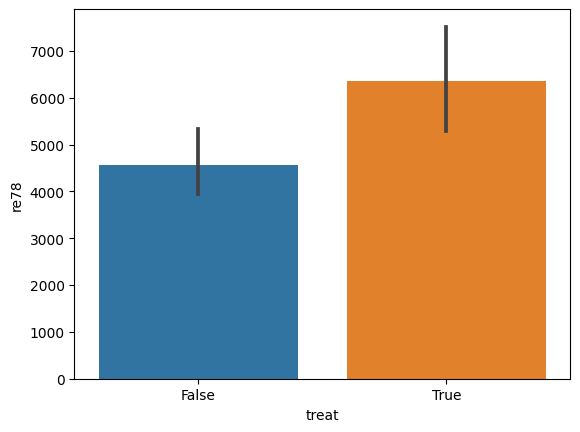

In [13]:
import seaborn as sns

sns.barplot(data=lalonde, x='treat', y='re78')

<AxesSubplot: xlabel='treat', ylabel='re78'>

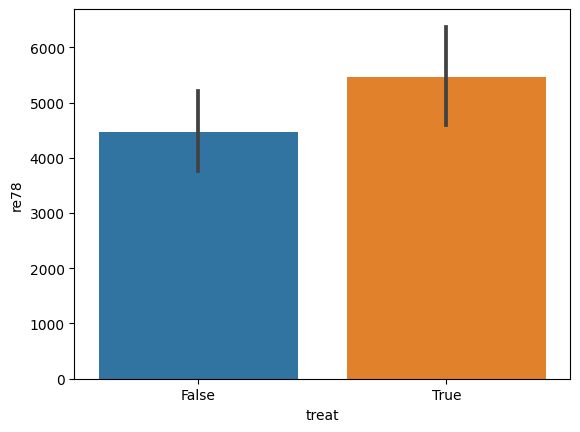

In [14]:
sns.barplot(data=do_df, x='treat', y='re78')

## Specifying Interventions

You can find the distribution of the outcome under an intervention to set the value of the treatment. 

In [15]:
do_df = lalonde.causal.do(x={'treat': 1},
                          outcome='re78',
                          common_causes=['nodegr', 'black', 'hisp', 'age', 'educ', 'married'],
                          variable_types={'age': 'c', 'educ':'c', 'black': 'd', 'hisp': 'd', 
                                          'married': 'd', 'nodegr': 'd','re78': 'c', 'treat': 'b'},
                         proceed_when_unidentifiable=True)

In [16]:
do_df.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,propensity_score,weight
0,True,22.0,12.0,0.0,0.0,0.0,0.0,6759.9940,8455.504,12590.710,0.0,0.0,0.574062,1.741973
1,True,25.0,11.0,1.0,0.0,0.0,1.0,0.0000,0.000,0.000,1.0,1.0,0.362386,2.759491
2,True,20.0,9.0,1.0,0.0,0.0,1.0,6083.9940,0.000,8881.665,0.0,1.0,0.378167,2.644335
3,True,24.0,11.0,1.0,0.0,1.0,1.0,824.3886,1666.113,4032.708,0.0,0.0,0.410571,2.435631
4,True,31.0,9.0,0.0,1.0,0.0,1.0,0.0000,0.000,26817.600,1.0,1.0,0.286864,3.485972


This new dataframe gives the distribution of `'re78'` when `'treat'` is set to `1`.

For much more detail on how the `do` method works, check the docstring:

In [17]:
help(lalonde.causal.do)

Help on method do in module dowhy.api.causal_data_frame:

do(x, method='weighting', num_cores=1, variable_types={}, outcome=None, params=None, dot_graph=None, common_causes=None, estimand_type='nonparametric-ate', proceed_when_unidentifiable=False, stateful=False) method of dowhy.api.causal_data_frame.CausalAccessor instance
    The do-operation implemented with sampling. This will return a pandas.DataFrame with the outcome
    variable(s) replaced with samples from P(Y|do(X=x)).
    
    If the value of `x` is left unspecified (e.g. as a string or list), then the original values of `x` are left in
    the DataFrame, and Y is sampled from its respective P(Y|do(x)). If the value of `x` is specified (passed with a
    `dict`, where variable names are keys, and values are specified) then the new `DataFrame` will contain the
    specified values of `x`.
    
    For some methods, the `variable_types` field must be specified. It should be a `dict`, where the keys are
    variable names, and